In [26]:
import concurrent
import ee
import geetools
import geemap
import io
import json
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import requests
import torch
import pandas as pd

In [2]:
ee.Authenticate()

True

In [3]:
ee.Initialize(project='ee-spencerscw-snow', opt_url='https://earthengine-highvolume.googleapis.com')

In [4]:
SENTINEL = ee.ImageCollection("COPERNICUS/S1_GRD")

In [5]:
station_info = pd.read_json('./stations.json')
station_info.set_index('stationTriplet', inplace=True)
station_info.loc['ABY:CA:SNOW']

stationId                    ABY
stateCode                     CA
networkCode                 SNOW
name                       Abbey
dcoCode                       UN
countyName                Plumas
huc               180201220103.0
elevation                   5760
latitude                  39.955
longitude               -120.538
beginDate       1963-02-01 00:00
endDate         2100-01-01 00:00
shefId                       NaN
dataTimeZone                 NaN
pedonCode                    NaN
Name: ABY:CA:SNOW, dtype: object

In [6]:
depth_2022 = pd.read_json('./depth_2022.json')
depth_2023 = pd.read_json('./depth_2023.json')
depth_2024 = pd.read_json('./depth_2024.json')
depths = []

for year in [depth_2022, depth_2023, depth_2024]:
    for stationTriplet, data in year.itertuples(index=False):
        try:
            latitude = station_info.loc[stationTriplet].latitude
            longitude = station_info.loc[stationTriplet].longitude
            for value in data[0]['values']:
                date = value['date']
                depth = value['value']
                if depth > 0:
                    depths.append({'latitude': latitude, 'longitude': longitude, 'date': date, 'depth': depth})
        except KeyError:
            pass

depth_df = pd.DataFrame(depths)

In [7]:
depth_df

,latitude,longitude,date,depth
0,41.23583,-120.79192,2022-01-01,38
1,41.23583,-120.79192,2022-01-02,37
2,41.23583,-120.79192,2022-01-03,36
3,41.23583,-120.79192,2022-01-04,37
4,41.23583,-120.79192,2022-01-05,35
...,...,...,...,...
524439,40.79492,-106.59544,2024-12-27,39
524440,40.79492,-106.59544,2024-12-28,44
524441,40.79492,-106.59544,2024-12-29,48
524442,40.79492,-106.59544,2024-12-30,47


In [30]:
sample_coords = [depth_df.iloc[0].longitude, depth_df.iloc[0].latitude]

point = ee.Geometry.Point(sample_coords).buffer(1000)
#point = ee.Geometry.Point(-122.196, 41.411)
sample_image = ee.Image(SENTINEL.filterBounds(point).filterDate(ee.Date('2022-01-01'), ee.Date('2022-01-15')).first().clip(point))

sample_image.bandNames().getInfo()

torch.tensor(geemap.ee_to_numpy(sample_image, region=point)).shape

torch.Size([201, 200, 3])

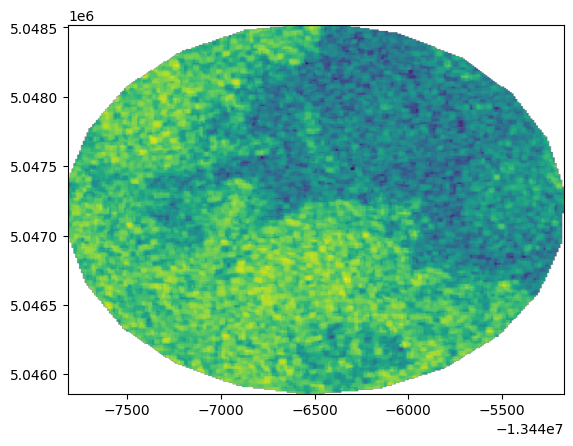

In [9]:
fig, ax = plt.subplots()

sample_image.geetools.plot(
    bands = ["VV"],
    ax = ax,
    region=point,
    crs="EPSG:3857",
    scale=10,
    cmap="viridis",
    color="k"
)

plt.show()

In [22]:
date = ee.Date(depth_df.iloc[0].date)

date = date.advance(15, 'days')

date.format().getInfo()

'2022-01-16T00:00:00'

In [35]:
from torch.utils.data import Dataset

class SnowDataset(Dataset):
    def __init__(self, depth_df):
        self.depth_df = depth_df
    
    def __len__(self):
        return len(self.depth_df)
    
    def __getitem__(self, idx):
        lat, long, date, depth = self.depth_df.iloc[idx]
        point = ee.Geometry.Point([long, lat]).buffer(1000)
        start_date = ee.Date(date)
        end_date = start_date.advance(15, 'days')
        image = ee.Image(SENTINEL.filterBounds(point).filterDate(start_date, end_date).first().clip(point))
        image_tensor = torch.tensor(geemap.ee_to_numpy(image, region=point))
        
        return image_tensor, depth

# Time Log:
## Research, data collection, API practice (total: 8.5 hours)
- 3/3 1.5 hours: Read docs for TorchGeo and Google Earth Engine
- 3/4 2.5 hours: Reread papers from my literature review to find in situ snow measurements
- 3/5 2 hours: Downloaded and cleaned the snow data
- 3/6 2.5 hours: Used Earth Engine API to download and display an S2 image for one target location

## Designing, building, debugging, testing, analyzing, experimenting
- 4/10 2 hours: Wrote the Dataset class and Dataloader to grab images dynamically from Earth Engine for the in-situ observations.